In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [3]:
def rigid_transform_3D(A, B):
    assert len(A) == len(B)
    N = A.shape[0]  # total points

    centroid_A = np.mean(A, axis=0) # mean of all points
    centroid_B = np.mean(B, axis=0) # mean of all points

    AA = A - centroid_A # remove offset
    BB = B - centroid_B # remove offset

    H = AA.T @ BB # correlation

    U, S, Vt = np.linalg.svd(H) # singular value decomposition
    R = Vt.T @ U.T # rotation

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B.T - R @ centroid_A.T

    return R, t

def apply_transformation(d_xyz, R, t):
    return d_xyz @ R.T + t

In [12]:
# NEW CANONICAL SPACE

#datapath="/cluster/project/hilliges/mbressieux/log/plate_novel_view"
datapath="/M2SSD1/Logs/Def_3DGS/cup_novel_view"

xyz=np.load(os.path.join(datapath,"can_xyz.npy")) #size nb_gaussx3
d_xyz=np.load(os.path.join(datapath,"can_d_xyz.npy")) #size timestampxnb_gaussx3
d_scaling=np.load(os.path.join(datapath,"can_d_scaling.npy")) #size timestampx3

print(xyz.shape)
print(d_xyz.shape)
print(d_scaling.shape)

(125499, 3)
(807, 125499, 3)
(807, 125499, 3)


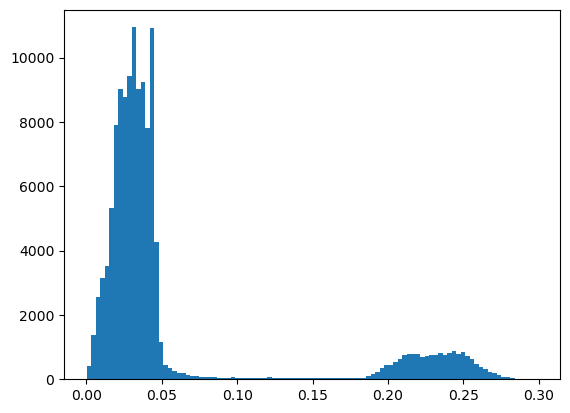

In [27]:
# d_xyz is the 3D gaussian movement [timestep,n_gauss,3]

# We want to find the rigid motion that best fits the data

#we take the first timestep as the canonical space
canonical_d_xyz=xyz #size nb_gaussx3
timestamp=400

#we want to find the rotation and translation that best fits the data at timestamp

# Use Ransac to estimate if some gaussians are moving in rigid motion
# A rigid motion is a motion that can be described by a rotation and a translation
# We can estimate the rotation and translation using Ransac
# Then we can remove the first rigid motion from the data and repeat the process to find the next rigid motion

#step 1: take a subset of the data
idx=np.random.choice(d_xyz.shape[1],size=1000,replace=False)
subset1=xyz[idx]
subset2=xyz[idx] + d_xyz[timestamp,idx]

#step 2: find the rotation and translation that best fit the data
R, t = rigid_transform_3D(subset1,subset2)

#step 3: apply the transformation to the whole data
transformed_d_xyz=apply_transformation(xyz+d_xyz[timestamp], R, t)

#step 4: compute the error
error=np.linalg.norm(transformed_d_xyz-xyz,axis=1)

#step 5: plot the error
plt.hist(error,bins=100)
plt.show()












In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator, RegressorMixin

def rigid_transform_3D(A, B):
    assert len(A) == len(B)
    N = A.shape[0]  # total points

    centroid_A = np.mean(A, axis=0) # mean of all points
    centroid_B = np.mean(B, axis=0) # mean of all points

    AA = A - centroid_A # remove offset
    BB = B - centroid_B # remove offset

    H = AA.T @ BB # correlation

    U, S, Vt = np.linalg.svd(H) # singular value decomposition
    R = Vt.T @ U.T # rotation

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B.T - R @ centroid_A.T

    return R, t

def apply_transformation(d_xyz, R, t):
    return d_xyz @ R.T + t

class RigidTransformModel(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.R, self.t = rigid_transform_3D(X, y)
        return self

    def predict(self, X):
        return apply_transformation(X, self.R, self.t)

# NEW CANONICAL SPACE

datapath = "/M2SSD1/Logs/Def_3DGS/cup_novel_view"

xyz = np.load(os.path.join(datapath, "can_xyz.npy"))  # size nb_gaussx3
d_xyz = np.load(os.path.join(datapath, "can_d_xyz.npy"))  # size timestampxnb_gaussx3
d_scaling = np.load(os.path.join(datapath, "can_d_scaling.npy"))  # size timestampx3

print(xyz.shape)
print(d_xyz.shape)
print(d_scaling.shape)

# d_xyz is the 3D gaussian movement [timestep, n_gauss, 3]

# We want to find the rigid motion that best fits the data

# we take the first timestep as the canonical space
canonical_d_xyz = xyz  # size nb_gaussx3
timestamp = 400

# Use RANSAC to estimate if some gaussians are moving in rigid motion
# A rigid motion is a motion that can be described by a rotation and a translation
# We can estimate the rotation and translation using RANSAC
# Then we can remove the first rigid motion from the data and repeat the process to find the next rigid motion

nb_rigid_motions = 10

inliers_arr = []
rigid_rot = []
rigid_t = []

for i in range(nb_rigid_motions):

    # step 1: take a subset of the data
    idx = np.random.choice(d_xyz.shape[1], size=1000, replace=False)
    subset1 = xyz[idx]
    subset2 = xyz[idx] + d_xyz[timestamp, idx]

    # step 2: use RANSAC to find the rotation and translation that best fit the data
    ransac = RANSACRegressor(estimator=RigidTransformModel(), min_samples=1000, residual_threshold=0.05, max_trials=100)
    ransac.fit(xyz, xyz + d_xyz[timestamp])

    # Check if RANSAC found a valid consensus set
    if ransac.inlier_mask_.sum() == 0:
        print("RANSAC could not find a valid consensus set. Try adjusting the parameters.")
    else:
        # Get the estimated rigid transformation
        R, t = ransac.estimator_.R, ransac.estimator_.t

        # Get the inliers and outliers
        inliers = ransac.inlier_mask_
        outliers = ~inliers

        # Print the number of inliers
        print(f"Number of inliers: {inliers.sum()}")
        print(f"Number of outliers: {outliers.sum()}")

        # step 3: apply the transformation to the whole data
        transformed_d_xyz = apply_transformation(xyz + d_xyz[timestamp], R, t)

        # step 4: compute the error
        error = np.linalg.norm(transformed_d_xyz - xyz, axis=1)

        # step 5: plot the error
        """plt.hist(error, bins=100)
        plt.show()"""

        """# step 6: plot the inliers and outliers
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xyz[inliers, 0], xyz[inliers, 1], xyz[inliers, 2], c='b', label='Inliers')
        ax.scatter(xyz[outliers, 0], xyz[outliers, 1], xyz[outliers, 2], c='r', label='Outliers')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.show()"""

    # step 7: remove the inliers and repeat the process
    xyz = xyz[outliers]
    d_xyz = d_xyz[:, outliers]

    # step 8: store the rigid motion
    rigid_rot.append(R)
    rigid_t.append(t)
    
    #step 9: store the inliers and restore initial size using former inliers
    inliers_arr.append(inliers)
    inliers=np.zeros(len(outliers),dtype=bool)
    


rigid_rot=np.array(rigid_rot)
rigid_t=np.array(rigid_t)
inliers_arr=np.array(inliers_arr)


(125499, 3)
(807, 125499, 3)
(807, 125499, 3)
Number of inliers: 99478
Number of outliers: 26021
Number of inliers: 1423
Number of outliers: 24598
Number of inliers: 349
Number of outliers: 24249
Number of inliers: 52
Number of outliers: 24197
Number of inliers: 24
Number of outliers: 24173


/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Number of inliers: 10
Number of outliers: 24163
Number of inliers: 22
Number of outliers: 24141


/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Number of inliers: 11
Number of outliers: 24130
Number of inliers: 12
Number of outliers: 24118


/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/micka/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/

Number of inliers: 4
Number of outliers: 24114


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [68]:
inliers_arr[0].shape

(125499,)

In [53]:
rigid_motions=np.array(rigid_motions)
inliers_arr=np.array(inliers_arr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (10, 2, 3) + inhomogeneous part.

In [54]:
len(rigid_motions)


10

In [39]:
R

array([[ 0.9999505 , -0.00170804, -0.00979979],
       [ 0.00145509,  0.99966717, -0.02575985],
       [ 0.00984054,  0.02574423,  0.99962014]], dtype=float32)

In [28]:
# Randomly sample a subset of points
np.random.seed(42)  # For reproducibility
idx = np.random.choice(d_xyz.shape[1], size=1000, replace=False)
subset_canonical = canonical_d_xyz[idx]
subset_timestamp = d_xyz[timestamp][idx]


# Estimate the transformation from inliers
R_est, t_est = rigid_transform_3D(subset_canonical, subset_timestamp)

In [31]:
t_est

array([ 0.02520336,  0.00405271, -0.00646819], dtype=float32)

In [6]:
canonical_d_xyz

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)